In [1]:
import pickle
import os
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../graphnet/src')
sys.path.insert(0, '../gnn_testbed')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.05"

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
import random
from jax import random
from jax import numpy as jnp

import torch
import torch_cluster
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from nemesis.event_generation.detector import make_line, generate_noise, Detector, make_triang
from nemesis.plotting import plot_event, plot_events, plot_confusion
from nemesis.data_handling.utils import event_labelling
from nemesis.node_features.feature_generation import generate_features
from nemesis.evaluation.evaluation import model_evaluation, energy_division_loaders, energy_evaluation
from nemesis.evaluation.utils import count_parameters
from nemesis.models.train import train_model
from nemesis.models.gnns import Dynamic_class, DynEdge_modified

from torch.nn import Linear, Identity, ReLU, Softmax, Dropout, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, TAGConv, global_mean_pool, global_max_pool, BatchNorm,  global_add_pool, EdgeConv, DynamicEdgeConv

from graphnet.models.gnn.dynedge import DynEdge
from graphnet.components.layers import DynEdgeConv
from graphnet.models.gnn.gnn import GNN
from graphnet.models.utils import calculate_xyzt_homophily, calculate_xyz_homophily_POne

%matplotlib inline


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


CUDA
graphnet: INFO     2023-03-22 18:05:49 - get_logger - Writing log to logs/graphnet_20230322-180549.log


INFO:graphnet:Writing log to logs/graphnet_20230322-180549.log


In [2]:
outpath = "."
plt.rcParams['figure.dpi'] = 100
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print('CPU')

CUDA


In [3]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m
v_x = 0
efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency, v_x=v_x, buoy_weight=30)
module_positions = jnp.asarray(det.module_coords)

In [4]:
def load_all_events(it):
    path_to_events = "/dss/pone/pone_events/all_events"
    load_array = ['cascades_15000ev_3.5-6.5_1.pickle',  'cascades_15000ev_3.5-6.5_2.pickle',
                  'cascades_15000ev_3.5-6.5_3.pickle',  'cascades_15000ev_3.5-6.5_4.pickle',
                  'stracks_15000ev_3.5-6.5_1.pickle',   'stracks_15000ev_3.5-6.5_2.pickle', 
                  'stracks_15000ev_3.5-6.5_3.pickle',   'stracks_15000ev_3.5-6.5_4.pickle', 
                  'tracks_15000ev_3.5-6.5_1.pickle',    'tracks_15000ev_3.5-6.5_2.pickle', 
                  'tracks_15000ev_3.5-6.5_3.pickle',    'tracks_15000ev_3.5-6.5_4.pickle']
            
    events, records = pickle.load(open(os.path.join(path_to_events, load_array[it]), "rb"))
    
    print(f'{it} loaded!')
    
    return events, records

In [ ]:
Radius = 100
k = 15
cascade_labels, track_labels, strack_labels = event_labelling(track_records, strack_records, cascade_records, det_hull=(Radius,1000))
all_events = cascades + tracks + stracks
all_records = cascade_records + track_records + strack_records
all_labels = cascade_labels + track_labels + strack_labels
data_array = generate_features(det, all_events, all_labels, k=k)
pickle.dump(data_array,open(f"/dss/pone/pone_events/features_arrays/data_array_{180}k_k{k}_R{Radius}.pickle", "wb"))

In [8]:
Radius = 'out' #100, 75
k=15
data_array = pickle.load(open(f"/dss/pone/pone_events/features_arrays/data_array_{180}k_k{k}_R{Radius}.pickle", "rb"))

In [12]:
from nemesis.models.gnns import MLP
class Dynamic_class(torch.nn.Module):
    
    def __init__(self, out_channels, k, aggr='max', bigMLP=True):
        super().__init__()

        self.conv11 = TAGConv(15, 64, K=4)
        self.conv12 = TAGConv(64, 64, K=4)
        self.BatchNorm1 = BatchNorm(64)

        if bigMLP:
            b = [64, 64, 32]
            c = [2*32, 64, 64]
            d = [2*64, 32, 32]
        else:
            b = [64, 128, 128]
            c = [2*128, 64, 64]
            d = [2*64, 128, 128]
            
        self.conv21 = TAGConv(b[0], b[1], K=3)
        self.conv22 = TAGConv(b[1], b[2], K=3)
        self.BatchNorm2 = BatchNorm(b[2])

        self.conv31 = DynamicEdgeConv(Linear(c[0], c[1]), k, aggr)        
        self.conv32 = DynamicEdgeConv(Linear(c[1]*2, c[2]), k, aggr)
        self.BatchNorm3 = BatchNorm(c[2])

        self.conv41 = DynamicEdgeConv(Linear(d[0], d[1]), k, aggr)
        self.conv42 = DynamicEdgeConv(Linear(2*d[1], d[2]), k, aggr)
        self.BatchNorm4 = BatchNorm(d[2])
        
        if bigMLP:
            self.lin1 = Linear((64*2 + 32*2), 128)
            self.mlp = MLP([128, 32, out_channels], dropout=0.5)
        else:
            self.lin1 = Linear((64*2 + 128*2), 2048)
            self.mlp = MLP([2048, 2048, 1024, 1024, 512, 512, 256, 256, out_channels], dropout=0.5)


    def forward(self, x):#, edge_index, batch):
        x, edge_index, batch = x.x, x.edge_index, x.batch
        x1 = self.conv11(x, edge_index).relu()
        x1 = self.conv12(x1, edge_index).relu()
        x1 = self.BatchNorm1(x1)
        x11 = global_max_pool(x1, batch)        

        x2 = self.conv21(x1, edge_index).relu()
        x2 = self.conv22(x2, edge_index).relu()
        x2 = self.BatchNorm2(x2)
        x21 = global_max_pool(x2, batch)

        x3 = self.conv31(x2, batch)
        x3 = self.conv32(x3, batch)
        x3 = self.BatchNorm3(x3)
        x31 = global_max_pool(x3, batch)

        x4 = self.conv41(x3, batch)
        x4 = self.conv42(x4, batch)
        x4 = self.BatchNorm4(x4)
        x41 = global_max_pool(x4, batch)
    
        out = self.lin1(torch.cat([x11, x21, x31, x41], dim=1))


        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

In [ ]:
import random
random.seed(982356)

indices = np.arange(len(data_array))
random.shuffle(indices)


shuffled_data = [data_array[i] for i in indices]
split_test = int(len(shuffled_data)*0.95)
training_data = shuffled_data[:split_test]
split_val = int(len(training_data)*0.9)
train_dataset = training_data[:split_val]
val_dataset = training_data[split_val:]

test_dataset = shuffled_data[split_test:]
test_indices = indices[split_test:]

epochs = 250
patience=50
batch_size=250
lr=0.001
layer_size_scale = 4
print_step = 1
#model = DynEdge_modified(15, 4, k = k, features_subset = slice(12, 15), layer_size_scale=layer_size_scale)
model = Dynamic_class(4, k=k, )
model.to(device)
label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}
model, all_trains_acc, all_vals_acc = train_model(model, train_dataset, val_dataset, label_map, k=k, epochs=epochs, patience=patience, print_step=print_step, batch_size=batch_size, lr=lr)
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 000, Train Acc: 0.7026, Val Acc: 0.7674, patience: 0
Epoch: 001, Train Acc: 0.8005, Val Acc: 0.8305, patience: 1
Epoch: 002, Train Acc: 0.8359, Val Acc: 0.8489, patience: 1
Epoch: 003, Train Acc: 0.8522, Val Acc: 0.8616, patience: 1
Epoch: 004, Train Acc: 0.8596, Val Acc: 0.8743, patience: 1
Epoch: 005, Train Acc: 0.8665, Val Acc: 0.8763, patience: 1
Epoch: 006, Train Acc: 0.8709, Val Acc: 0.8790, patience: 1
Epoch: 007, Train Acc: 0.8741, Val Acc: 0.8777, patience: 1
Epoch: 008, Train Acc: 0.8772, Val Acc: 0.8863, patience: 2
Epoch: 009, Train Acc: 0.8819, Val Acc: 0.8780, patience: 1
Epoch: 010, Train Acc: 0.8843, Val Acc: 0.8891, patience: 2
Epoch: 011, Train Acc: 0.8862, Val Acc: 0.8973, patience: 1
Epoch: 012, Train Acc: 0.8892, Val Acc: 0.8944, patience: 1
Epoch: 013, Train Acc: 0.8903, Val Acc: 0.8915, patience: 2
Epoch: 014, Train Acc: 0.8931, Val Acc: 0.9001, patience: 3
Epoch: 015, Train Acc: 0.8944, Val Acc: 0.8984, patience: 1
Epoch: 016, Train Acc: 0.8954, Val Acc: 

In [26]:
model

Dynamic_class(
  (conv11): TAGConv(15, 64, K=4)
  (conv12): TAGConv(64, 64, K=4)
  (BatchNorm1): BatchNorm(64)
  (conv21): TAGConv(64, 64, K=3)
  (conv22): TAGConv(64, 32, K=3)
  (BatchNorm2): BatchNorm(32)
  (conv31): DynamicEdgeConv(nn=Linear(in_features=64, out_features=64, bias=True), k=15)
  (conv32): DynamicEdgeConv(nn=Linear(in_features=128, out_features=64, bias=True), k=15)
  (BatchNorm3): BatchNorm(64)
  (conv41): DynamicEdgeConv(nn=Linear(in_features=128, out_features=32, bias=True), k=15)
  (conv42): DynamicEdgeConv(nn=Linear(in_features=64, out_features=32, bias=True), k=15)
  (BatchNorm4): BatchNorm(32)
  (lin1): Linear(in_features=192, out_features=128, bias=True)
  (mlp): MLP(128, 32, 4)
)

In [27]:
import os
from datetime import datetime

path_to_models = "/dss/pone/nemesis_trained_models/"
a = datetime.now()
today_folder = f'{a.strftime("%b")}{a.day}/'
n_events = len(data_array)
R='out'
k=15
layer_size_scale=4
lr=0.001
n_events=len(data_array)
batch_size=250
model_name = "Dynamic_class"

filename = f'{model_name}_{int(n_events/1000)}k_R{R}_k{k}_B{batch_size}_L{layer_size_scale}_lr{lr}.pt'

path_to_save = os.path.join(path_to_models, today_folder)
if os.path.isdir(path_to_save):
    
    if os.path.isfile(os.path.join(path_to_save, filename)):
        print(f"file {filename} already exist")
    else:
        torch.save(model, os.path.join(path_to_save, filename))
        print(f"file {filename} saved")
else:
    os.makedirs(path_to_save)
    torch.save(model, os.path.join(path_to_save, filename))
    print(f"file {filename} saved")

file Dynamic_class_180k_Rout_k15_B250_L4_lr0.001.pt already exist


In [30]:
pickle.dump((all_trains_acc, all_vals_acc), open(os.path.join(path_to_save, filename+"_acc.pickle"), "wb"))

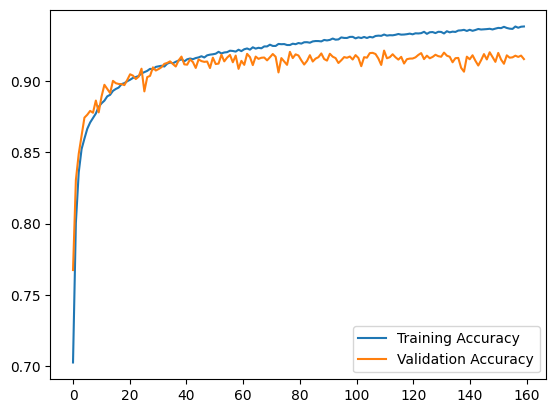

In [28]:
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()

In [43]:
date = 'Mar14'
model_name = 'Dyn_own'
n_events = 180
R = 100
k = 15
batch_size = 250
layer_size_scale = 4
lr = 0.001
v_x = 0.005
model = torch.load(f'/dss/pone/nemesis_trained_models/{date}/{model_name}_{n_events}k_R{R}_k{k}_B{batch_size}_L{layer_size_scale}_lr{lr}.pt')
path_to_test_loaders = "/dss/pone/pone_events/features_arrays/test_data_array/"
#test_energy_loaders = pickle.load(open(path_to_test_loaders+f"/test_energy_loaders_90k_k{k}_R{R}_B{batch_size}_11divisions.pickle", "rb"))
test_energy_loader = pickle.load(open(path_to_test_loaders+f"vx_loaders/test_loader_k{k}_R{R}_v_x{v_x}.pickle", "rb"))
all_records_test = pickle.load(open(path_to_test_loaders+f"all_records_test_90k_k8_R75_v_x.pickle", "rb"))
records_test = all_records_test[:4500]
loader = DataLoader(test_energy_loader, batch_size=200, shuffle=False)


In [95]:
from nemesis.data_handling.event_loading import load_test_events
det, cascades, cascade_records, tracks, track_records, stracks, strack_records = load_test_events(v_x)
cascade_labels_test, track_labels_test, strack_labels_test = event_labelling(track_records, strack_records, cascade_records, det_hull=(R,1000))
all_labels_test = cascade_labels_test + track_labels_test + strack_labels_test

In [109]:
all_events_test = cascades + tracks + stracks
all_records_test = cascade_records + track_records + strack_records

In [170]:
log_emin = 3.5
log_emax = 6.5
energy = np.power(10, rng.uniform(log_emin, log_emax))
energy

21364.029987377908

In [148]:
test_preds, test_truths, test_scores, event_energy = [], [], [], []
all_preds_test_len = 0
for it, data in enumerate(loader):
    out = model(data.to(device))
    test_pred = out.argmax(dim=1)
    test_preds.append(test_pred)
    test_truths.append(data.y)
    energies = [ev.mc_info[0]['energy'] for ev in all_records_test[len(data)*it:len(data)*(it+1)]]
    event_energy += energies
    test_scores.append(out)
    all_preds_test_len+=len(data.y)

In [181]:
np.logspace(3.5,6.5,10)

array([   3162.27766017,    6812.92069058,   14677.99267622,
         31622.77660168,   68129.2069058 ,  146779.92676221,
        316227.76601684,  681292.06905796, 1467799.26762207,
       3162277.66016838])

In [183]:
print(np.power(10,3.5), np.power(10,6.5))

3162.2776601683795 3162277.6601683795


In [213]:
10//5

2

/home/work/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1003: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


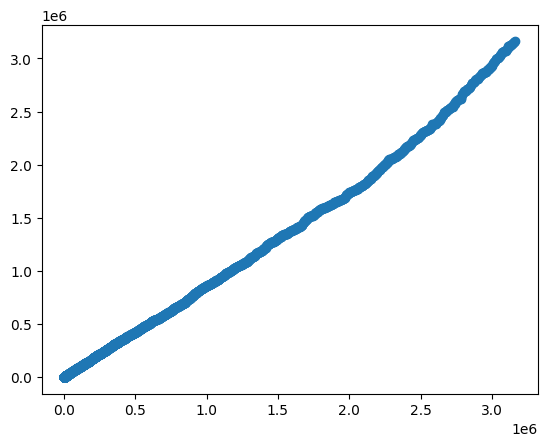

In [180]:
plt.scatter(np.linspac(1,100,4500), np.sort(event_energy))

In [223]:
sorted_energies = np.sort(event_energy)
energy_divisions = []
for i in range(10):
    first_energy = sorted_energies[len(sorted_energies)*i//10]
    last_energy = sorted_energies[len(sorted_energies)*(i+1)//10-1] 
    energy_divisions.append((first_energy, last_energy-100))


In [224]:
for j in energy_divisions:
    print(np.log10(j[0]), np.log10(j[1]), len([i for i in event_energy if i>j[0] and i<j[1]]))

0.5987660433344818 [3.69268843] 439
[3.70329626] 4.0286183684458345 441
4.032796696620305 4.340469892212146 445
4.343673469108159 4.653051231210302 444
4.654146743086652 [4.93892557] 447
[4.9397384] 5.23549853600378 448
5.235956869376501 5.538004796414244 448
5.538351574835076 [5.81957259] 447
[5.82132061] 6.13791590337918 448
6.138327587199982 [6.49980886] 448


In [130]:
for it, data in enumerate(loader):
    print(len(data)*it,len(data)*it+1)
    print([ev.mc_info[0]['energy'] for ev in all_records_test[len(data)*it:len(data)*(it+1)]])

0 1
[39393.74512231455, 1447527.1884153916, 458615.68267084035, 1523996.703026009, 496239.20265543915, 17130.635757339012, 43422.248864159155, 2408933.641206963, 18223.821462277276, 95963.90107413118, 24702.338480147355, 21523.722864053532, 1430924.8941538369, 39558.44242505617, 730570.2918410219, 140162.16130107365, 13264.925874757244, 60770.317035572094, 16608.044920943066, 76954.8356713156, 96747.26246187426, 6758.583167438105, 686206.7607850527, 118405.99104667317, 71054.02576068188, 456930.5140450029, 55735.002697895725, 19921.666929708543, 12386.962224444324, 1023532.8495952503, 339772.1447840636, 954144.0695338121, 689430.9337437797, 27781.539148839747, 372802.76310626656, 2313711.8337781415, 259366.0082400346, 1970078.4656523305, 32674.963008229508, 1744611.210264478, 2278752.0848721107, 30854.5025852243, 192168.49117243098, 240857.79916038306, 2255448.6206478495, 130143.13108097052, 15644.0020794227, 2337156.1212792373, 69744.5734969057, 4352.216253461213, 2294614.223811346, 1

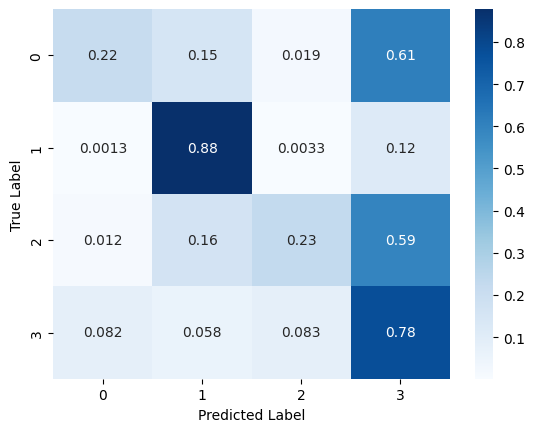

The accuracies of the different energy divisions are 63.82222222222222


In [74]:
import pandas as pd
fig, test_accuracies, misscls_idx=energy_evaluation(model, loader, plot_conf=True, label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}) 

In [73]:
def energy_evaluation(model, 
                      test_energy_loaders, 
                      plot_conf=True, 
                      label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}):    



    ## Checking for predictions
    with torch.no_grad():
        if type(test_energy_loaders) == list:
            nplt = int(np.ceil(np.sqrt(len(test_energy_loaders))))
            fig = plt.figure(figsize=(nplt * 4, nplt * 4))
            pbar = tqdm(total=90000/250)
            test_accuracies = []
            for i, loader in enumerate(test_energy_loaders):
                test_preds = []
                test_truths = []
                test_scores = []
                all_preds_test_len = 0

                for data in loader:  # Iterate in batches over the training/test dataset.
                    out = model(data)
                    #print(out.shape)
                    test_pred = out.argmax(dim=1)
                    test_preds.append(test_pred)
                    test_truths.append(data.y)
                    test_scores.append(out)
                    all_preds_test_len+=len(data.y)
                    pbar.update()

                test_preds = torch.cat(test_preds).cpu()
                test_truths = torch.cat(test_truths).cpu()
                test_scores = torch.cat(test_scores).cpu()
                misscls_idx = np.atleast_1d(np.argwhere(test_preds != test_truths).ravel())
                test_accuracy = 100 * (all_preds_test_len - len(misscls_idx)) / all_preds_test_len
                all_preds = []
                
                for j in range(len(label_map)):
                    true_sel = test_truths == j
                    predictions = np.histogram(test_preds[true_sel], bins=np.arange(0, len(label_map)+1, 1))[0]
                    if predictions.sum() == 0:
                        predictions = predictions
                    else:
                        predictions = predictions / predictions.sum()
                    all_preds.append(predictions)

                all_preds = np.vstack(all_preds)
                test_accuracies.append(test_accuracy)
                
                if plot_conf:
                    ax = fig.add_subplot(nplt, nplt, i + 1)
                    ax1 = sns.heatmap(all_preds, cmap=plt.cm.Blues, annot=True, ax=ax)# xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), ax=ax)
                    ax1.set_xlabel("Predicted Label")
                    ax1.set_ylabel("True Label")
                #ax1.set_title()
                #fig1 = ax.get_figure()
                
                ax, ax1 = 0,0
        else:
            fig = plt.figure()
            test_preds = []
            test_truths = []
            test_scores = []
            all_preds_test_len = 0
            loader = test_energy_loaders

            for data in loader:  # Iterate in batches over the training/test dataset.
                out = model(data)
                #print(out.shape)
                test_pred = out.argmax(dim=1)
                test_preds.append(test_pred)
                test_truths.append(data.y)
                test_scores.append(out)
                all_preds_test_len+=len(data.y)
                
            test_preds = torch.cat(test_preds).cpu()
            test_truths = torch.cat(test_truths).cpu()
            test_scores = torch.cat(test_scores).cpu()
            misscls_idx = np.atleast_1d(np.argwhere(test_preds != test_truths).ravel())
            test_accuracy = 100 * (all_preds_test_len - len(misscls_idx)) / all_preds_test_len
            all_preds = []
            
            for j in range(len(label_map)):
                true_sel = test_truths == j
                predictions = np.histogram(test_preds[true_sel], bins=np.arange(0, len(label_map)+1, 1))[0]
                if predictions.sum() == 0:
                    predictions = predictions
                else:
                    predictions = predictions / predictions.sum()
                all_preds.append(predictions)

            all_preds = np.vstack(all_preds)
            test_accuracies = test_accuracy
            
            if plot_conf:
                ax = fig.add_subplot(1, 1, 1)
                fig = sns.heatmap(all_preds, cmap=plt.cm.Blues, annot=True, ax=ax)# xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), ax=ax)
                fig.set_xlabel("Predicted Label")
                fig.set_ylabel("True Label")
        

    plt.show()
    print('The accuracies of the different energy divisions are', test_accuracies)

    return fig, test_accuracies, misscls_idx

In [12]:
test_energy_loaders

NameError: name 'test_energy_loaders' is not defined

/tmp/ipykernel_3669629/2862412127.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")


<AxesSubplot: xlabel='Task', ylabel='Model'>

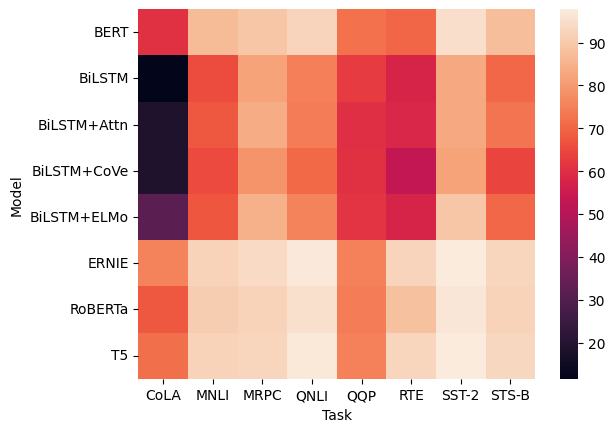

In [6]:
glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")
sns.heatmap(glue)

In [7]:
glue

Task,CoLA,MNLI,MRPC,QNLI,QQP,RTE,SST-2,STS-B
Model,,,,,,,,
BERT,60.5,86.7,89.3,92.7,72.1,70.1,94.9,87.6
BiLSTM,11.6,65.6,81.8,74.6,62.5,57.4,82.8,70.3
BiLSTM+Attn,18.6,67.6,83.9,74.3,60.1,58.4,83.0,72.8
BiLSTM+CoVe,18.5,65.4,78.7,70.8,60.6,52.7,81.9,64.4
BiLSTM+ELMo,32.1,67.2,84.7,75.5,61.1,57.4,89.3,70.3
ERNIE,75.5,92.3,93.9,97.3,75.2,92.6,97.8,93.0
RoBERTa,67.8,90.8,92.3,95.4,74.3,88.2,96.7,92.2
T5,71.6,92.2,92.8,96.9,75.1,92.8,97.5,93.1


  0%|          | 0/90000 [00:00<?, ?it/s]

first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done
first half done
second half done


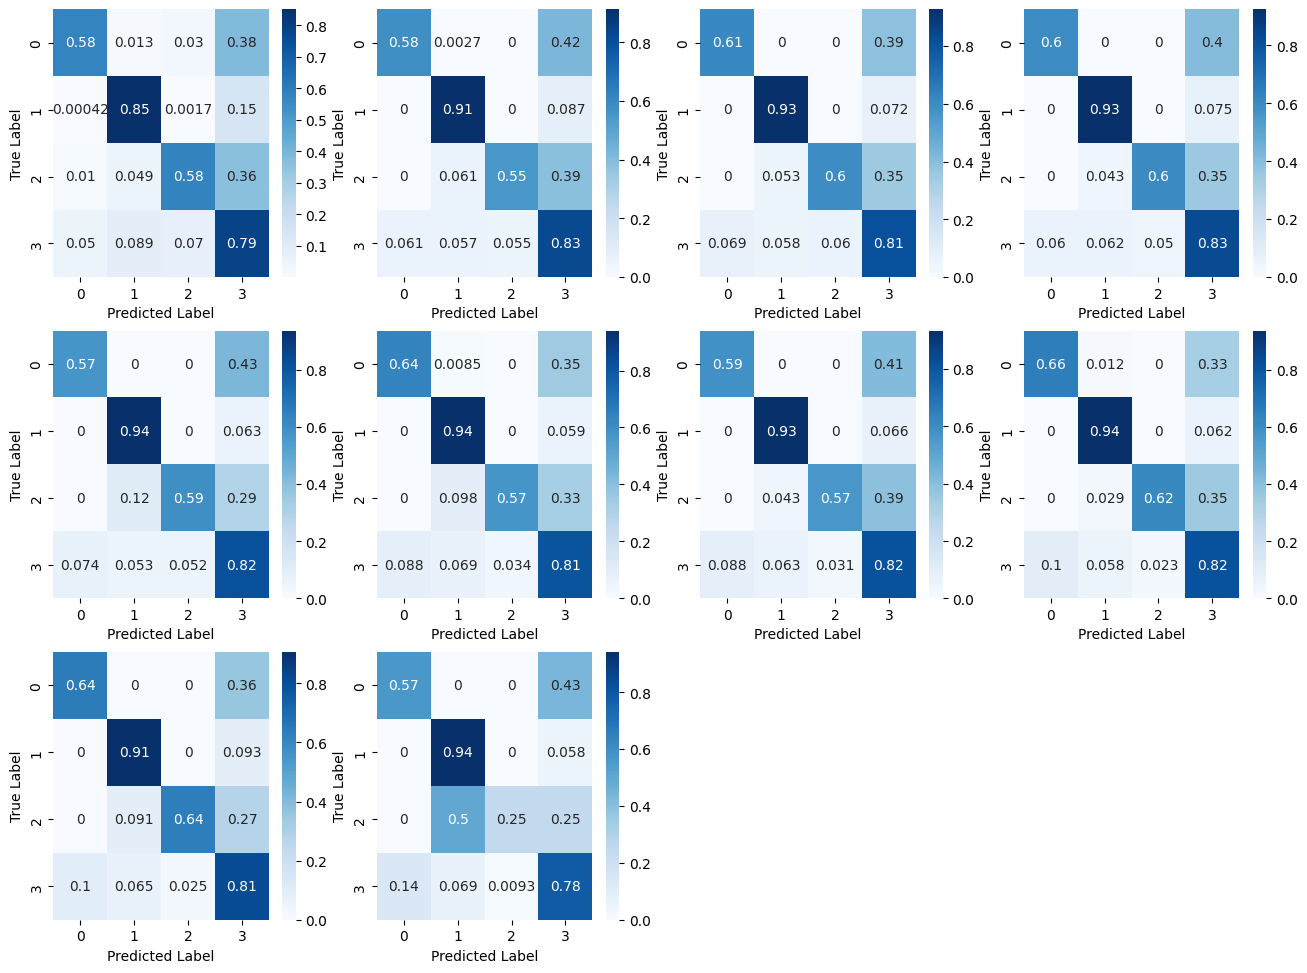

The accuracies of the different energy divisions are [78.97736394284797, 83.50935093509351, 83.8192701293686, 84.67583497053045, 84.62138953942232, 84.6722523410547, 85.04728132387707, 85.78869047619048, 84.6683893195521, 85.30762167125803]


In [38]:
fig, test_accuracies, misscls_idx=energy_evaluation(model, test_energy_loaders, plot_conf=True, label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}) 

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_intervals_histogram(intervals, function_values):
    # calculate the widths of the intervals
    widths = np.diff(intervals)

    # create a figure and axis object
    fig, ax = plt.subplots()

    # plot the histogram of function values for each interval
    ax.bar(intervals[:-1], function_values, width=widths, align='edge')

    # set the x and y axis labels
    ax.set_xlabel('Intervals')
    ax.set_ylabel('Function Values')

    # show the plot
    plt.show()
    return fig
    

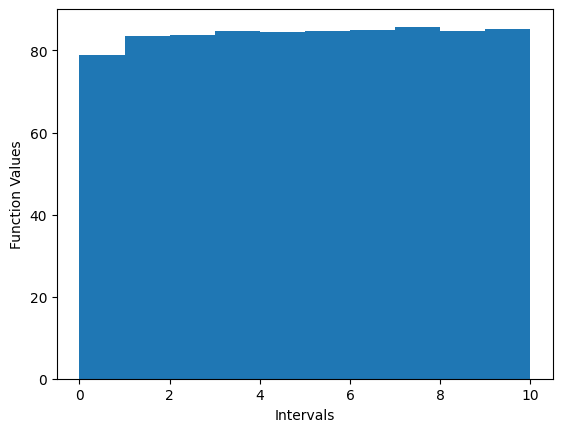

In [40]:
    
intervals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
function_values = test_accuracies

fig = plot_intervals_histogram(intervals, function_values)

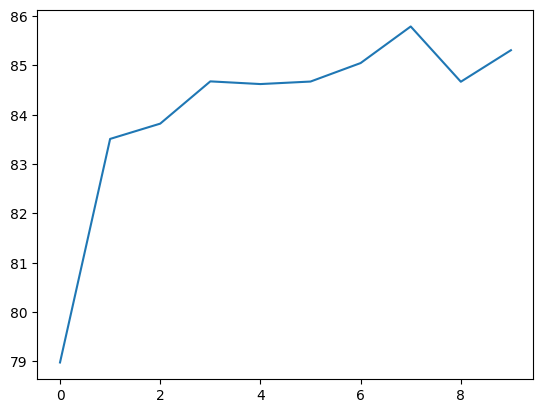

In [43]:
plt.plot(intervals[:-1], function_values)